In [7]:
import pandas as pd
import numpy as np
#from filterpy.kalman import KalmanFilter
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv(r'D:\time series va do an\TH1_TTNT\test.csv')
df.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
0,750000,Educational Nuggets,Episode 73,78.96,Education,38.11,Saturday,Evening,53.33,1.0,Neutral
1,750001,Sound Waves,Episode 23,27.87,Music,71.29,Sunday,Morning,NaN,0.0,Neutral
2,750002,Joke Junction,Episode 11,69.10,Comedy,67.89,Friday,Evening,97.51,0.0,Positive
3,750003,Comedy Corner,Episode 73,115.39,Comedy,23.40,Sunday,Morning,51.75,2.0,Positive
4,750004,Life Lessons,Episode 50,72.32,Lifestyle,58.10,Wednesday,Morning,11.30,2.0,Neutral


# 1. Tiền xử lí dữ liệu

In [9]:
df.count()

id                             250000
Podcast_Name                   250000
Episode_Title                  250000
Episode_Length_minutes         221264
Genre                          250000
Host_Popularity_percentage     250000
Publication_Day                250000
Publication_Time               250000
Guest_Popularity_percentage    201168
Number_of_Ads                  250000
Episode_Sentiment              250000
dtype: int64

=> Dữ liệu tại 2 thuộc tính Episode_Length_minutes và Guest_Popularity_percentage bị thiếu nhiều

In [10]:
df.isnull().sum()

id                                 0
Podcast_Name                       0
Episode_Title                      0
Episode_Length_minutes         28736
Genre                              0
Host_Popularity_percentage         0
Publication_Day                    0
Publication_Time                   0
Guest_Popularity_percentage    48832
Number_of_Ads                      0
Episode_Sentiment                  0
dtype: int64

=> Trực quan hóa dữ liệu bị thiếu 

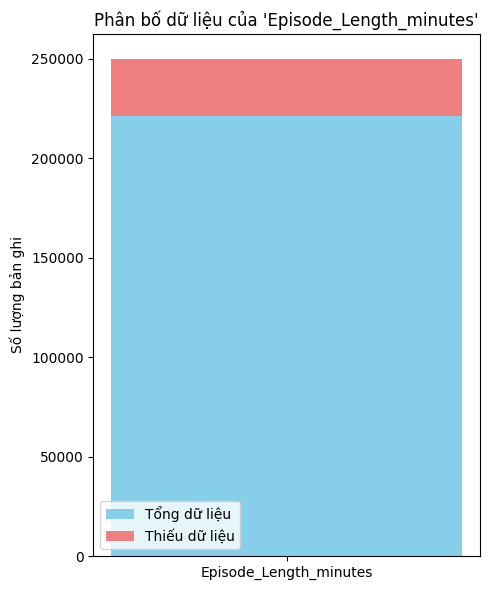

In [13]:
# Chọn cột cần kiểm tra
column = "Episode_Length_minutes"

# Tính số lượng dữ liệu
total = len(df)
missing = df[column].isnull().sum()
non_missing = total - missing

# Dữ liệu cho biểu đồ
data = [non_missing, missing]
labels = ["Có dữ liệu", "Thiếu dữ liệu"]
colors = ["skyblue", "lightcoral"]

# Vẽ biểu đồ
plt.figure(figsize=(5, 6))
plt.bar(column, total, color='skyblue', label="Tổng dữ liệu")
plt.bar(column, missing, bottom=non_missing, color='lightcoral', label="Thiếu dữ liệu")

# Thêm chú thích
plt.title(f"Phân bố dữ liệu của '{column}'")
plt.ylabel("Số lượng bản ghi")
plt.legend()
plt.tight_layout()
plt.show()

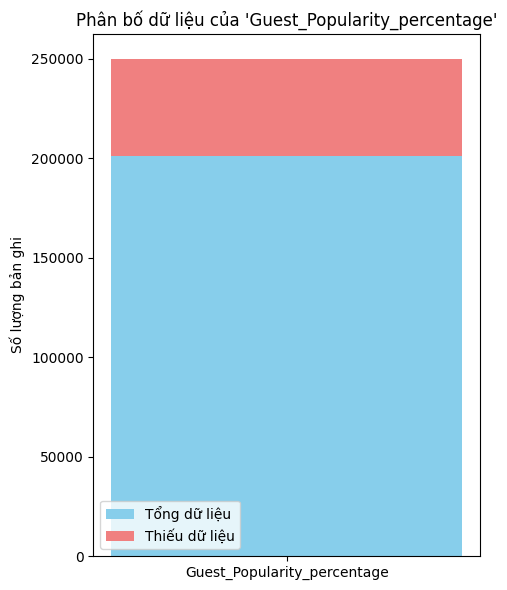

In [15]:
# Chọn cột cần kiểm tra
column = "Guest_Popularity_percentage"

# Tính số lượng dữ liệu
total = len(df)
missing = df[column].isnull().sum()
non_missing = total - missing

# Dữ liệu cho biểu đồ
data = [non_missing, missing]
labels = ["Có dữ liệu", "Thiếu dữ liệu"]
colors = ["skyblue", "lightcoral"]

# Vẽ biểu đồ
plt.figure(figsize=(5, 6))
plt.bar(column, total, color='skyblue', label="Tổng dữ liệu")
plt.bar(column, missing, bottom=non_missing, color='lightcoral', label="Thiếu dữ liệu")

# Thêm chú thích
plt.title(f"Phân bố dữ liệu của '{column}'")
plt.ylabel("Số lượng bản ghi")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
df["Episode_Length_minutes"] = df["Episode_Length_minutes"].interpolate(method='linear')

In [17]:
df["Guest_Popularity_percentage"] = df.groupby("Genre")["Guest_Popularity_percentage"]\
                                       .transform(lambda x: x.fillna(x.median()))

In [18]:
df.isnull().sum()

id                             0
Podcast_Name                   0
Episode_Title                  0
Episode_Length_minutes         0
Genre                          0
Host_Popularity_percentage     0
Publication_Day                0
Publication_Time               0
Guest_Popularity_percentage    0
Number_of_Ads                  0
Episode_Sentiment              0
dtype: int64

# Dữ liệu sau khi đã tiền xử lí

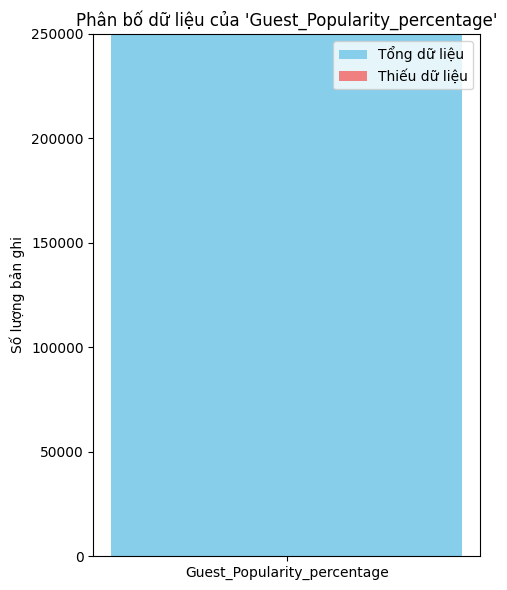

In [19]:
# Chọn cột cần kiểm tra
column = "Guest_Popularity_percentage"

# Tính số lượng dữ liệu
total = len(df)
missing = df[column].isnull().sum()
non_missing = total - missing

# Dữ liệu cho biểu đồ
data = [non_missing, missing]
labels = ["Có dữ liệu", "Thiếu dữ liệu"]
colors = ["skyblue", "lightcoral"]

# Vẽ biểu đồ
plt.figure(figsize=(5, 6))
plt.bar(column, total, color='skyblue', label="Tổng dữ liệu")
plt.bar(column, missing, bottom=non_missing, color='lightcoral', label="Thiếu dữ liệu")

# Thêm chú thích
plt.title(f"Phân bố dữ liệu của '{column}'")
plt.ylabel("Số lượng bản ghi")
plt.legend()
plt.tight_layout()
plt.show()

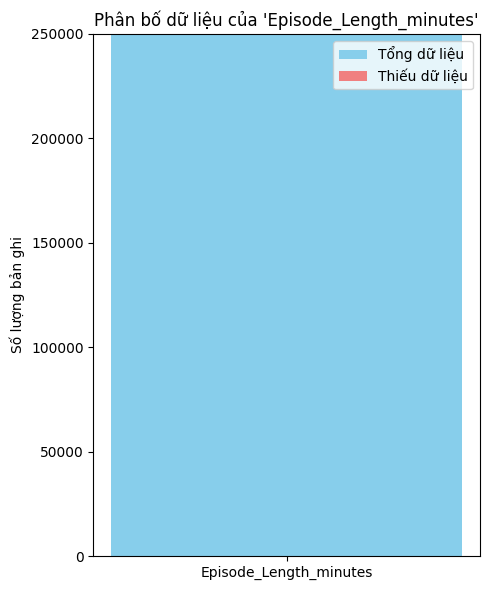

In [20]:
# Chọn cột cần kiểm tra
column = "Episode_Length_minutes"

# Tính số lượng dữ liệu
total = len(df)
missing = df[column].isnull().sum()
non_missing = total - missing

# Dữ liệu cho biểu đồ
data = [non_missing, missing]
labels = ["Có dữ liệu", "Thiếu dữ liệu"]
colors = ["skyblue", "lightcoral"]

# Vẽ biểu đồ
plt.figure(figsize=(5, 6))
plt.bar(column, total, color='skyblue', label="Tổng dữ liệu")
plt.bar(column, missing, bottom=non_missing, color='lightcoral', label="Thiếu dữ liệu")

# Thêm chú thích
plt.title(f"Phân bố dữ liệu của '{column}'")
plt.ylabel("Số lượng bản ghi")
plt.legend()
plt.tight_layout()
plt.show()

2.

# 1. Kalman filter cơ bản

Ước lượng Listening_Time_minutes dựa trên mô hình trạng thái đơn giản.

In [4]:
# Giá trị thực tế
observations = df['Listening_Time_minutes'].dropna().values
n = len(observations)

# kalman param
Q = 1e-5
R = np.var(observations - np.mean(observations))
xhat1 = np.zeros(n)
P = np.zeros(n)
xhat1minus = np.zeros(n)
Pminus = np.zeros(n)
K = np.zeros(n)

# Giá trị khởi tạo
xhat1[0] = observations[0]
P[0] = 1.0

for k in range(1, n):
    xhat1minus[k] = xhat1[k-1]
    Pminus[k] = P[k-1] + Q
    K[k] = Pminus[k] / (Pminus[k] + R)
    xhat1[k] = xhat1minus[k] + K[k] * (observations[k] - xhat1minus[k])
    P[k] = (1 - K[k]) * Pminus[k]

# result
plt.figure(figsize=(15, 5))
plt.plot(observations, label='Observed', alpha=0.5)
plt.plot(xhat1, label='Kalman Estimate', color='red')
plt.title('Kalman Filter (Basic) - Listening Time')
plt.xlabel('Episode Index')
plt.ylabel('Listening Time (minutes)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


KeyError: 'Listening_Time_minutes'

# 2. Kalman filter with Trend

mô hình này không chỉ theo dõi giá trị hiện tại mà còn ước lượng được xu hướng

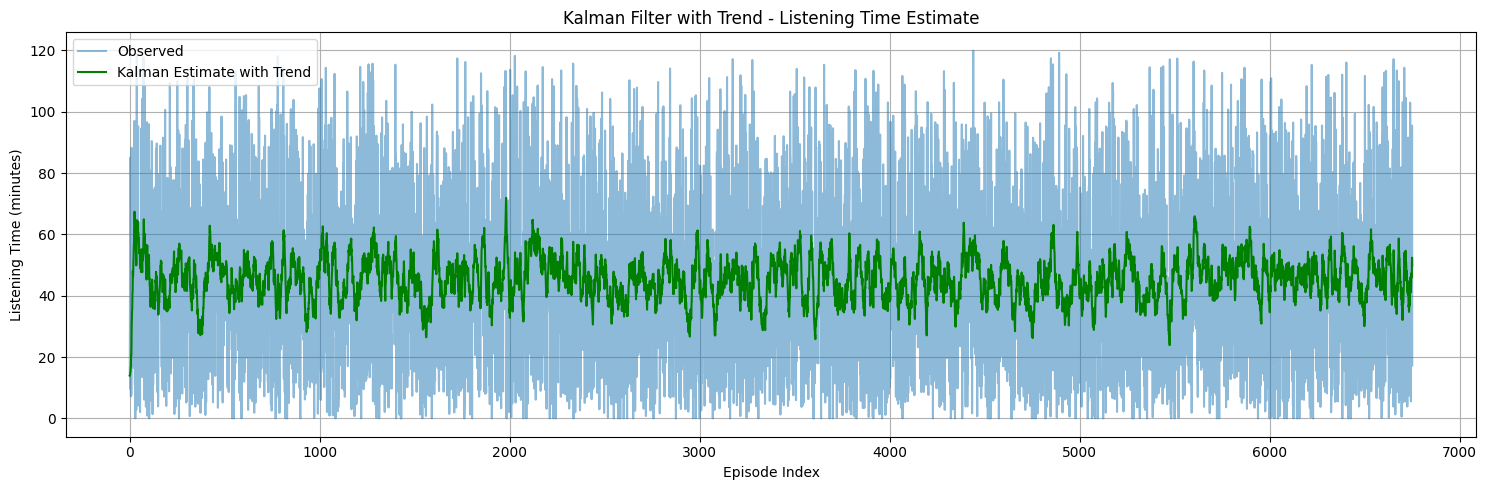

In [ ]:
# Giá trị thực tế
observations = df['Listening_Time_minutes'].dropna().values
n = len(observations)

# Ma trận hệ số
A = np.array([[1, 1], [0, 1]])  # Trạng thái gồm giá trị và xu hướng
H = np.array([[1, 0]])          # Chỉ quan sát giá trị

# Khởi tạo các biến
x_est = np.zeros((n, 2))        # Trạng thái ước lượng [giá trị, xu hướng]
P = np.zeros((n, 2, 2))         # Ma trận hiệp phương sai
Q = np.eye(2) * 0.01            # Nhiễu quá trình
R = np.array([[np.var(observations)]])  # Nhiễu quan sát
I = np.eye(2)

# Giá trị ban đầu
x_est[0] = [observations[0], 0]
P[0] = np.eye(2)

# Thuật toán Kalman
for k in range(1, n):
    # Dự đoán
    x_pred = A @ x_est[k-1]
    P_pred = A @ P[k-1] @ A.T + Q

    # Kalman Gain
    S = H @ P_pred @ H.T + R
    K = P_pred @ H.T @ np.linalg.inv(S)

    # Cập nhật
    y = observations[k] - H @ x_pred
    x_est[k] = x_pred + K.flatten() * y
    P[k] = (I - K @ H) @ P_pred

# result
plt.figure(figsize=(15, 5))
plt.plot(observations, label='Observed', alpha=0.5)
plt.plot(x_est[:, 0], label='Kalman Estimate with Trend', color='green')
plt.title('Kalman Filter with Trend - Listening Time Estimate')
plt.xlabel('Episode Index')
plt.ylabel('Listening Time (minutes)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# 3. Kalman filter mở rộng với biến quan sát phụ

- Dùng thêm biến quan sát phụ (không chỉ dùng Listening_Time_minutes nữa)
- Chọn Episode_Length_minutes vì thời lượng tập podcast có thể ảnh hưởng đến thời gian nghe.

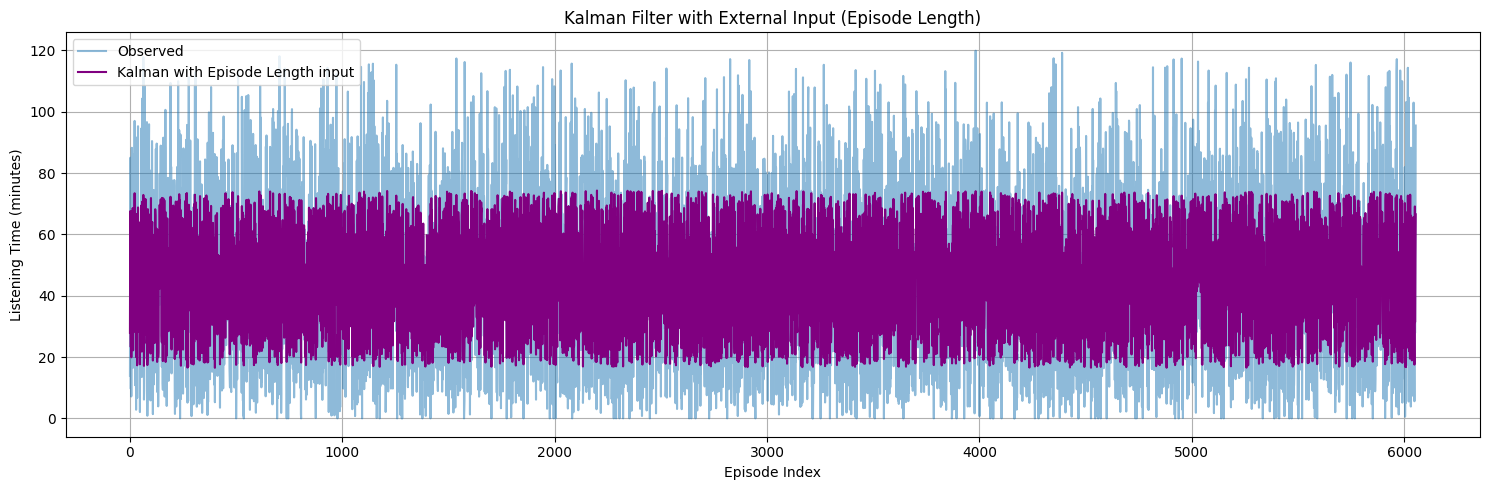

In [ ]:
# Lấy dữ liệu
obs = df[['Listening_Time_minutes', 'Episode_Length_minutes']].dropna()
z = obs['Listening_Time_minutes'].values
u = obs['Episode_Length_minutes'].values
n = len(z)

# Khởi tạo tham số
xhat = np.zeros(n)  # trạng thái ẩn
P = np.zeros(n)     # hiệp phương sai
Q = 1e-5            # nhiễu quá trình
R = np.var(z)       # nhiễu quan sát
H = 1.0             # hệ số trạng thái
B = 0.5             # hệ số tác động của biến phụ
xhat[0] = z[0]
P[0] = 1.0

# Kalman Filter có input phụ
for k in range(1, n):
    # Dự đoán
    xhat_minus = xhat[k-1]
    P_minus = P[k-1] + Q

    # Tính sai số đo
    y = z[k] - (H * xhat_minus + B * u[k])  # residual

    # Kalman Gain
    K = P_minus * H / (H * P_minus * H + R)

    # Cập nhật
    xhat[k] = xhat_minus + K * y
    P[k] = (1 - K * H) * P_minus

# result
plt.figure(figsize=(15, 5))
plt.plot(z, label='Observed', alpha=0.5)
plt.plot(xhat + B * u, label='Kalman with Episode Length input', color='purple')
plt.title('Kalman Filter with External Input (Episode Length)')
plt.xlabel('Episode Index')
plt.ylabel('Listening Time (minutes)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Đánh giá mô hình

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

z = df['Listening_Time_minutes'].dropna().values
u = df['Episode_Length_minutes'].dropna().values

# Đồng bộ độ dài tối thiểu giữa z, u, xhat1, x_est, xhat
min_len = min(len(z), len(u), len(xhat1), len(x_est), len(xhat))

z = z[:min_len]
u = u[:min_len]
kalman1 = xhat1[:min_len]
kalman2 = x_est[:min_len, 0]
kalman3 = xhat[:min_len] + B * u[:min_len]

# Đánh giá từng mô hình
def evaluate_model(name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{name}:\n   MSE = {mse:.4f}\n   MAE = {mae:.4f}\n   R2 = {r2:.4f}")

print("Đánh giá các mô hình Kalman:")
evaluate_model("Kalman 1 - Cơ bản", z, kalman1)
evaluate_model("Kalman 2 - Xu hướng", z, kalman2)
evaluate_model("Kalman 3 - Có biến phụ", z, kalman3)


Đánh giá các mô hình Kalman:
Kalman 1 - Cơ bản:
   MSE = 852.8482
   MAE = 23.7834
   R2 = -0.1426
Kalman 2 - Xu hướng:
   MSE = 672.4912
   MAE = 21.4870
   R2 = 0.0991
Kalman 3 - Có biến phụ:
   MSE = 993.4821
   MAE = 25.5009
   R2 = -0.3310
